In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/final-dataset/Mineral composition REGOMIX.xlsx


In [ ]:
#BELOW IS THE CODE FOR KNN IMPUTATION.

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def clean_impute_and_scale(df_subset, region_label):
    # Identify columns to keep for imputation (≤40% missing)
    min_non_na_columns = int(df_subset.shape[0] * 0.4)
    cols_to_keep = df_subset.columns[df_subset.isnull().sum() <= (df_subset.shape[0] - min_non_na_columns)]
    cols_dropped = df_subset.columns.difference(cols_to_keep)

    # Work only with numeric columns for imputation drop non numeric columns
    numeric_cols = df_subset[cols_to_keep].select_dtypes(include=['float64', 'int64']).columns
    numeric_data = df_subset[numeric_cols]

    # Scale the numeric data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(numeric_data)

    # Apply KNN imputation
    imputer = KNNImputer(n_neighbors=4)
    imputed_scaled = imputer.fit_transform(scaled_data)

    # Inverse scale to original values
    imputed_original = scaler.inverse_transform(imputed_scaled)

    # Replace numeric columns with imputed values
    df_imputed_numeric = pd.DataFrame(imputed_original, columns=numeric_cols, index=numeric_data.index)

    # Copy original DataFrame
    df_final = df_subset.copy()

    # Update numeric columns with imputed values
    df_final.loc[df_imputed_numeric.index, numeric_cols] = df_imputed_numeric

    # Reinsert dropped columns (unchanged)
    for col in cols_dropped:
        df_final[col] = df_subset[col]

    # Add region label
    df_final['Region'] = region_label

    return df_final

# Load data
df1 = pd.read_excel('/kaggle/input/final-dataset/ORIGINAL DATASET REGOMIX-MINERAL COMPOSITION.xlsx', engine='openpyxl')   #IMPORT ORIGINAL DATSET FOR MINERAL COMPOSITON FROM REGOMIX DATASET FOLDER IN DRIVE
df = df1.copy()

# Create subsets
df_mare = df[(df['Source'].str.contains('Mare', case=False, na=False)) & (df['Earth/Lunar'] == 'L')]
df_highland = df[(df['Source'].str.contains('Highland', case=False, na=False)) & (df['Earth/Lunar'] == 'L')]
df_earth = df[df['Earth/Lunar'] == 'E']

# Clean, impute, and scale each subset
imputed_mare = clean_impute_and_scale(df_mare, 'Mare')
imputed_highland = clean_impute_and_scale(df_highland, 'Highland')
imputed_earth = clean_impute_and_scale(df_earth, 'Earth')

# Combine all subsets
combined_df = pd.concat([imputed_mare, imputed_highland, imputed_earth], sort=False)

# Save to Excel
combined_df.to_excel('CLEANED DATASET REGOMIX-MINERAL COMPOSITION.xlsx', index=False)    #OUTPUT SAVED AS CLEANED DATASET IN REGOMIX DATSET FOLDER IN DRIVE


In [9]:
#BELOW IS THE CODE FOR EVALUATING THE ACCURACY FOR KNN IMPUTATION

from sklearn.preprocessing import RobustScaler

def evaluate_knn_imputation(df_subset, region_label, missing_frac=0.05, random_state=42):
    numeric_cols = df_subset.select_dtypes(include=['float64', 'int64']).columns
    data = df_subset[numeric_cols].copy()

    np.random.seed(random_state)
    non_na_mask = ~data.isnull()
    mask = (np.random.rand(*data.shape) < missing_frac) & non_na_mask
    masked_data = data.mask(mask)

    # Drop columns all NaN after masking
    valid_columns = masked_data.columns[~masked_data.isna().all()]
    masked_data = masked_data[valid_columns]
    data = data[valid_columns]

    # Fill NaNs with median before scaling
    temp_masked_data = masked_data.copy()
    for col in temp_masked_data:
        median_val = temp_masked_data[col].median()
        temp_masked_data[col].fillna(median_val, inplace=True)

    # Use RobustScaler
    scaler = RobustScaler()
    scaled_masked = pd.DataFrame(scaler.fit_transform(temp_masked_data), columns=valid_columns, index=data.index)

    imputer = KNNImputer(n_neighbors=4)
    imputed_scaled = pd.DataFrame(imputer.fit_transform(scaled_masked), columns=valid_columns, index=data.index)

    imputed_data = pd.DataFrame(scaler.inverse_transform(imputed_scaled), columns=valid_columns, index=data.index)

    original = data[mask[valid_columns]]
    predicted = imputed_data[mask[valid_columns]]

    original_flat = original.values.flatten()
    predicted_flat = predicted.values.flatten()

    valid_idx = ~np.isnan(original_flat)
    original_flat = original_flat[valid_idx]
    predicted_flat = predicted_flat[valid_idx]

    mse = mean_squared_error(original_flat, predicted_flat)
    r2 = r2_score(original_flat, predicted_flat)

    print(f"[{region_label}] KNN Imputation — MSE: {mse:.4f}, R²: {r2:.4f}")
    return mse, r2


# Evaluate imputation performance on each subset
evaluate_knn_imputation(df_mare, "Mare")
evaluate_knn_imputation(df_highland, "Highland")
evaluate_knn_imputation(df_earth, "Earth")


[Mare] KNN Imputation — MSE: 7.5223, R²: 0.9511
[Highland] KNN Imputation — MSE: 22.5592, R²: 0.8617
[Earth] KNN Imputation — MSE: 110.9542, R²: 0.8917


/tmp/ipykernel_36/3524630924.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  temp_masked_data[col].fillna(median_val, inplace=True)
/tmp/ipykernel_36/3524630924.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

(110.95416875000001, 0.891733069031218)

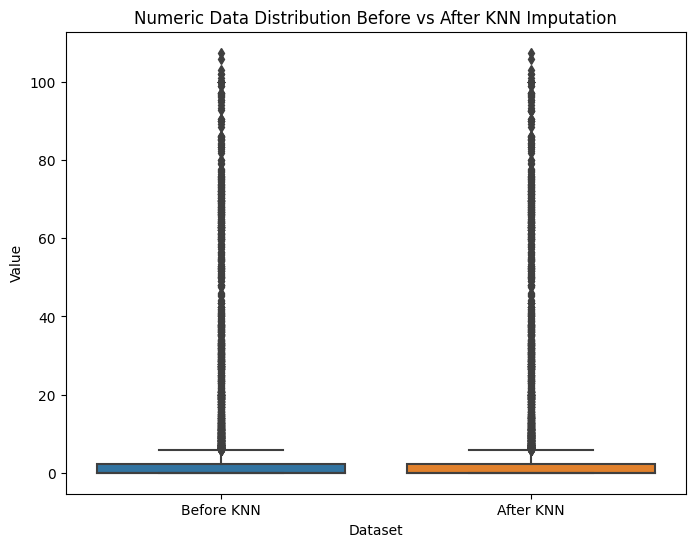

In [11]:
#BELOW IS THE CODE FOR VISUALIZING KNN IMPUTATION USING BOX AND PLOT DIAGRAM

import matplotlib.pyplot as plt
import seaborn as sns

# Collect numeric data before and after imputation
numeric_before = df.select_dtypes(include=['float64', 'int64']).values.flatten()
numeric_after = combined_df.select_dtypes(include=['float64', 'int64']).values.flatten()

# Drop NaN values from before (since after imputation has no NaN)
numeric_before = numeric_before[~np.isnan(numeric_before)]

# Create a dataframe for plotting
plot_df = pd.DataFrame({
    "Value": np.concatenate([numeric_before, numeric_after]),
    "Dataset": ["Before KNN"] * len(numeric_before) + ["After KNN"] * len(numeric_after)
})

# Single boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x="Dataset", y="Value", data=plot_df)
plt.title("Numeric Data Distribution Before vs After KNN Imputation")
plt.show()
